In [1]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 

In [2]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/SOM_models/SKIM_LIT/big_model_4_ip')

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [4]:
datadir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
# checking the filenames in the target directory 
import os 
file_names = [datadir + filename for filename in os.listdir(datadir)]

In [6]:
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

preprocessing the data now we've got some data it's time to becoming one with the data 
and one of the best of the way is to see the what data actually constists of

In [7]:
# let's write the functions to read in all of the lines of target text 

def get_lines(filename):
  with open(filename,'r') as f: 
    return f.readlines()

In [8]:
# reading lines in the training lines 
train_lines = get_lines(datadir + 'train.txt')

In [9]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
!nvidia-smi

Tue Jun 22 04:11:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |   2397MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# how the data can be represented 

```
[{'line_number':0,
'target':'BACKGROUND',
'text' : 'emotional eating is associated with eth overeating adn the development of obesity ' ,
'total_lines' : 11 },
...]
```

In [11]:
def preprocess_text_with_line_numbers(filename):
  """ 
  returns the list of the dictionary's of the abstarct line data 

  takes in file names and read it's contents and sort thorugh each lines
  extract things like the target label, text of the scentece , how many scentences are there in the focused abstract and what number the target liens is 

  """ 
  input_lines = get_lines(filename) # getting all the file names 
  abstract_lines = ""  # creating the empty abstract 
  abstract_samples = [] # creating the empty list of the abstract

  #looping through each lines in input)lines  

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line 
      abstract_lines = "" # resetting the abstract string if the lines is an id line 
    elif line.isspace():  # check to see if the line is the new line
       abstract_line_split = abstract_lines.splitlines() # splitting the abstract into sepearte lines 
       # iterate through each line in a single abstract 
       for abstract_line_number , abstract_line in enumerate(abstract_line_split):
         line_data = {} # create the empty dict for each line 
         target_text_split = abstract_line.split("\t") # splitting the target label with the tab 
         line_data['target'] = target_text_split[0]
         line_data['text'] = target_text_split[1].lower()
         line_data['line_number'] = abstract_line_number # what number does the line appear in the abstract 
         line_data['total_lines'] = len(abstract_line_split)- 1 # how many total liens are there in the target abstract 
         abstract_samples.append(line_data) # adding line data to the array to make the dictionary format 
    else: 
      abstract_lines += line
  return abstract_samples

In [12]:
%%time
train_samples = preprocess_text_with_line_numbers(datadir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(datadir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(datadir + 'test.txt')


CPU times: user 363 ms, sys: 103 ms, total: 466 ms
Wall time: 463 ms


In [13]:
len(train_samples), len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [14]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [16]:
val_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


In [17]:
!nvidia-smi

Tue Jun 22 04:11:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |   2397MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
# distribution of the lables in the training data 
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

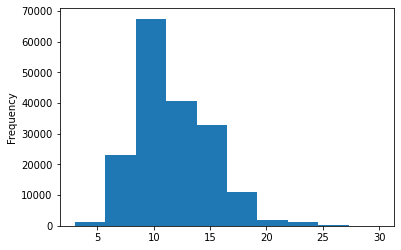

In [19]:
# length of the different lines 
train_df.total_lines.plot.hist()

# Getting list of all the scentences 

In [20]:
# convert the abstract text liens into the lists 
train_scentences = train_df.text.tolist()
val_scentences = val_df.text.tolist()
test_scentences = test_df.text.tolist()

In [21]:
len(train_scentences),len(val_scentences),len(test_scentences)

(180040, 30212, 30135)

## making the numeric labels ( numeric labels as well as the numeric data are required for ml algo to run) 


In [22]:
# one hot encode labels 
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder( sparse= False)  # we want non sparse matrix 
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1,1))
test_labes_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1,1))

# label encode labels 

In [23]:
# extract labels (target columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder() 
train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_df.target.to_numpy())

In [24]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [25]:
# getting classnames and the number of classes from label encoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [26]:
loaded_model.evaluate(test_)

NameError: ignored

In [29]:
text  = """As with most experimental research reports, the medical research paper
is a highly technical form with a standard format for the presentation of
information. This format is the division of the paper into "Introduction,
Methods, Results and Discussion" -- the traditional IMRD sections of the
research paper.
Most research article writers are familiar with the IMRD format, but not
all are conscious of the fact that there exists an internal ordering of the
information presented in the various sections of the research article. This
lack of awareness may account partly for the difficulty which most writers,
especially new entrants into the academic discourse community face with
producing clear, coherent and logically organized research reports. """

In [49]:
samples = []
if True:
  splitted_text = text.splitlines()
  print(splitted_text)
  for line_no,line in enumerate(splitted_text):
    line_data  = {}
    target_text = line.lower().replace('!@#$%^&*:",.<>',"")
    line_data['text'] = target_text.lower()
    line_data['line_number'] = line_no
    line_data['total_lines'] = len(splitted_text)- 1 
    samples.append(line_data)


samples

['As with most experimental research reports, the medical research paper', 'is a highly technical form with a standard format for the presentation of', 'information. This format is the division of the paper into "Introduction,', 'Methods, Results and Discussion" -- the traditional IMRD sections of the', 'research paper.', 'Most research article writers are familiar with the IMRD format, but not', 'all are conscious of the fact that there exists an internal ordering of the', 'information presented in the various sections of the research article. This', 'lack of awareness may account partly for the difficulty which most writers,', 'especially new entrants into the academic discourse community face with', 'producing clear, coherent and logically organized research reports. ']


[{'line_number': 0,
  'text': 'as with most experimental research reports, the medical research paper',
  'total_lines': 10},
 {'line_number': 1,
  'text': 'is a highly technical form with a standard format for the presentation of',
  'total_lines': 10},
 {'line_number': 2,
  'text': 'information. this format is the division of the paper into "introduction,',
  'total_lines': 10},
 {'line_number': 3,
  'text': 'methods, results and discussion" -- the traditional imrd sections of the',
  'total_lines': 10},
 {'line_number': 4, 'text': 'research paper.', 'total_lines': 10},
 {'line_number': 5,
  'text': 'most research article writers are familiar with the imrd format, but not',
  'total_lines': 10},
 {'line_number': 6,
  'text': 'all are conscious of the fact that there exists an internal ordering of the',
  'total_lines': 10},
 {'line_number': 7,
  'text': 'information presented in the various sections of the research article. this',
  'total_lines': 10},
 {'line_number': 8,
  'text': '

In [46]:
text.replace??

In [ ]:
 elif line.isspace():  # check to see if the line is the new line
       abstract_line_split = abstract_lines.splitlines() # splitting the abstract into sepearte lines 
       # iterate through each line in a single abstract 
       for abstract_line_number , abstract_line in enumerate(abstract_line_split):
         line_data = {} # create the empty dict for each line 
         target_text_split = abstract_line.split("\t") # splitting the target label with the tab 
         line_data['target'] = target_text_split[0]
         line_data['text'] = target_text_split[1].lower()
         line_data['line_number'] = abstract_line_number # what number does the line appear in the abstract 
         line_data['total_lines'] = len(abstract_line_split)- 1 # how many total liens are there in the target abstract 
         abstract_samples.append(line_data) # adding line data to the array to make the dictionary format 
    else: 
      abstract_lines += line

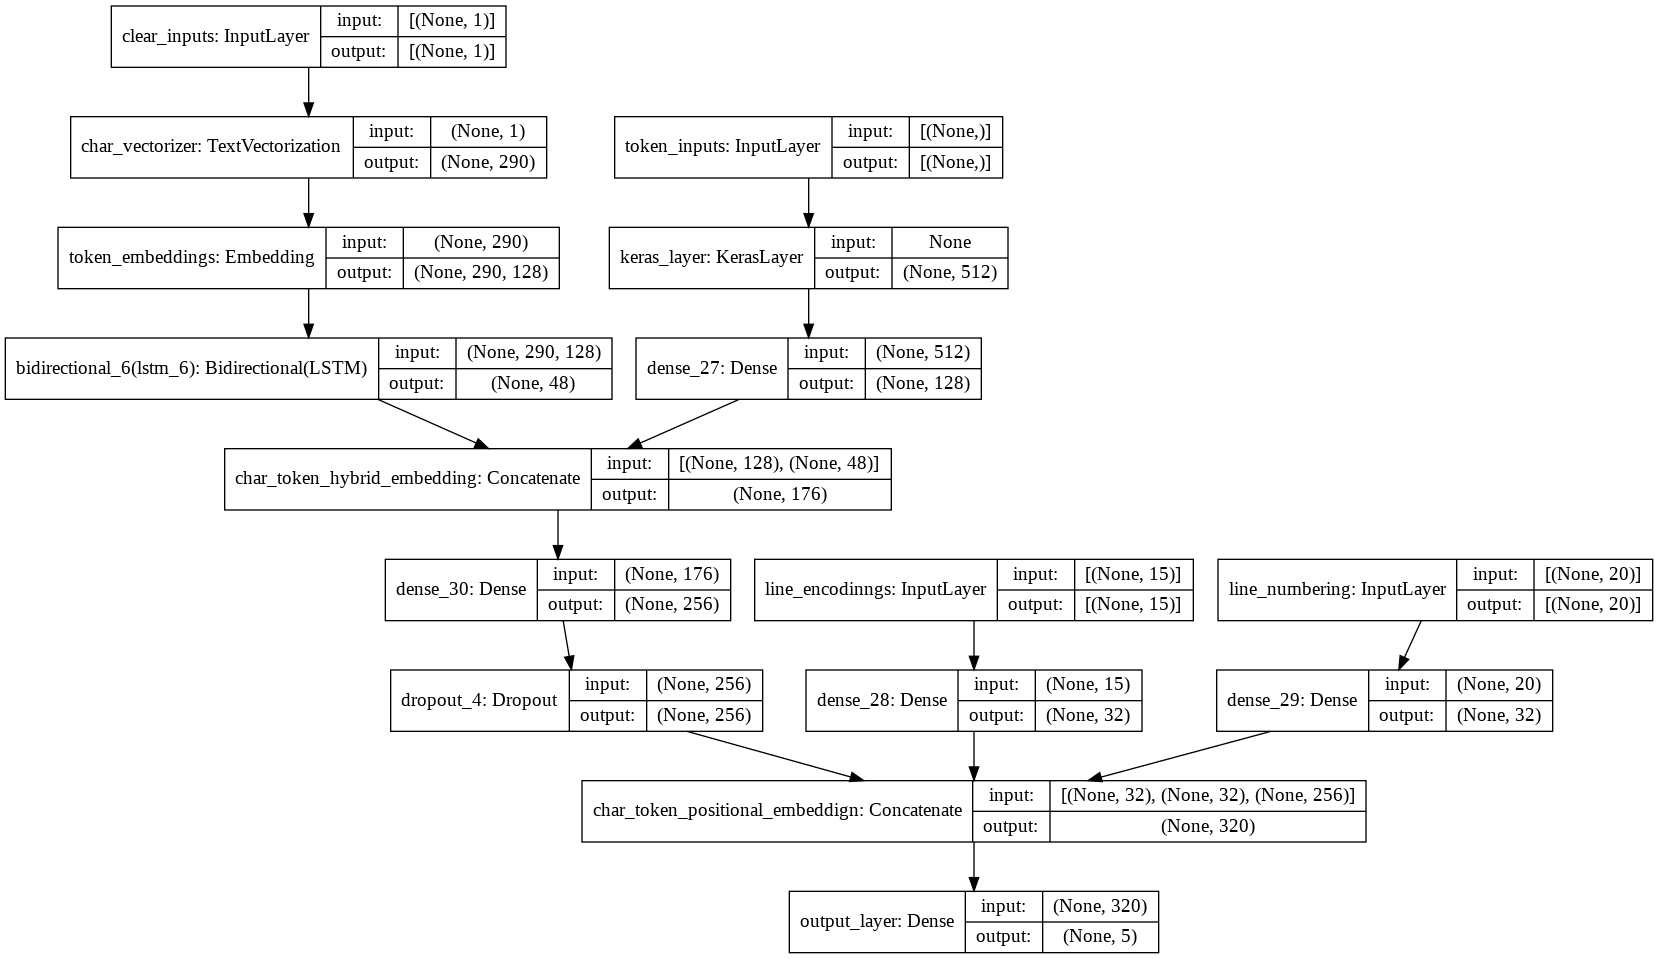

In [37]:
tf.keras.utils.plot_model(loaded_model,show_shapes=True)

In [54]:
def preprocess_text(text):
    samples = []
    splitted_text = text.splitlines()
    print(splitted_text)
    for line_no,line in enumerate(splitted_text):
        line_data  = {}
        target_text = line.lower().replace('!@#$%^&*:",.<>',"")
        line_data['text'] = target_text.lower()
        line_data['line_number'] = line_no
        line_data['total_lines'] = len(splitted_text)- 1 
        samples.append(line_data)
    
    dataframe = pd.DataFrame(samples)
    print(dataframe.head())

In [56]:
preprocess_text("""Over one year after its inception, the coronavirus disease-2019 (COVID-19) pandemic caused by severe acute respiratory syndrome coronavirus-2 (SARS-CoV-2) remains difficult to control despite the availability of several excellent vaccines. Progress in controlling the pandemic is slowed by the emergence of variants that appear to be more transmissible and more resistant to antibodies1,2. Here we report on a cohort of 63 COVID-19-convalescent individuals assessed at 1.3, 6.2 and 12 months after infection, 41% of whom also received mRNA vaccines3,4. In the absence of vaccination antibody reactivity to the receptor binding domain (RBD) of SARS-CoV-2, neutralizing activity and the number of RBD
-specific memory B cells remain relatively stable from 6 to 12 months. Vaccination increases all components of the humoral response, and as expected, results in serum neutralizing activities against variants of concern that are comparable to or greater than neutralizing activity against the original Wuhan Hu-1 achieved by 
vaccination of naive individuals2,5-8. The mechanism underlying these broad-based responses involves ongoing antibody somatic mutation, memory B cell clonal turnover, and development of monoclonal antibodies that are exceptionally resistant to SARS-CoV-2 RBD mutations, including 
those found in variants of concern4,9. In addition, B cell clones expressing broad and potent antibodies are selectively retained in the repertoire over time and expand dramatically after vaccination. The data 
suggest that immunity in convalescent individuals will be very long lasting and that convalescent individuals who receive available mRNA vaccines will produce antibodies and memory B cells that should be protective against circulating SARS-CoV-2 variants""")

['Over one year after its inception, the coronavirus disease-2019 (COVID-19) pandemic caused by severe acute respiratory syndrome coronavirus-2 (SARS-CoV-2) remains difficult to control despite the availability of several excellent vaccines. Progress in controlling the pandemic is slowed by the emergence of variants that appear to be more transmissible and more resistant to antibodies1,2. Here we report on a cohort of 63 COVID-19-convalescent individuals assessed at 1.3, 6.2 and 12 months after infection, 41% of whom also received mRNA vaccines3,4. In the absence of vaccination antibody reactivity to the receptor binding domain (RBD) of SARS-CoV-2, neutralizing activity and the number of RBD', '-specific memory B cells remain relatively stable from 6 to 12 months. Vaccination increases all components of the humoral response, and as expected, results in serum neutralizing activities against variants of concern that are comparable to or greater than neutralizing activity against the orig

In [195]:

def get_model(model_path):
    model = tf.keras.models.load_model(model_path)
    return model 

def split_char(text):
  return " ".join(list(text))

def preprocess_text(text):
    sample = []
    
    splitted_text = text.splitlines()

    for line_no,line in enumerate(splitted_text):
        line_data  = {}
        target_text = line.lower().replace('!@#$%^&*:",.<>',"")
        line_data['text'] = target_text.lower()
        line_data['line_number'] = line_no
        line_data['total_lines'] = len(splitted_text)- 1 
        sample.append(line_data)
    
    dataframe = pd.DataFrame(sample)
    
    textual_data_to_feed = dataframe.text.to_numpy()
    line_numbers_encoded = tf.one_hot(dataframe.line_number.to_numpy(),depth = 15)
    
    total_lines_encoded = tf.one_hot(dataframe.total_lines.to_numpy(),depth = 20)
    
    text_characters = [split_char(scentence) for scentence in textual_data_to_feed]
    return line_numbers_encoded,total_lines_encoded,textual_data_to_feed,text_characters
    

def predict_on_text(text,model):
    line_numbers,total_lines,text_data, text_char  = preprocess_text(text)
    prediction = model.predict((line_numbers,total_lines,tf.cast(text_data,'string'),tf.cast(text_char,'string')))
    array_of_preds = list(tf.argmax(prediction , axis = 1).numpy())
    pred_with_label = [class_names[x] for x in array_of_preds]

    return text_data, pred_with_label

def get_prediction(text):
    model = loaded_model
    output = predict_on_text(text,model)
    return output

In [247]:
textual,label =predict_on_text(
    text = """Over one year after its inception,
     the coronavirus disease-2019 (COVID-19) pandemic caused by severe acute respiratory syndrome coronavirus-2 (SARS-CoV-2) 
     remains difficult to control despite the availability of several excellent vaccines. 
     Progress in controlling the pandemic is slowed by the emergence of variants that appear to be more transmissible and more resistant to antibodies1,2. Here we report on a cohort of 63 COVID-19-convalescent individuals assessed at 1.3, 6.2 and 12 months after infection, 41% of whom also received mRNA vaccines3,4. In the absence of vaccination antibody reactivity to the receptor binding domain (RBD) of SARS-CoV-2, neutralizing activity and the number of RBD-specific memory B cells remain relatively stable from 6 to 12 months. Vaccination increases all components of the humoral response, and as expected, results in serum neutralizing activities against variants of concern that are comparable to or greater than neutralizing activity against the original Wuhan Hu-1 achieved by vaccination of naive individuals2,5-8. The mechanism underlying these broad-based responses involves ongoing antibody somatic mutation, memory B cell clonal turnover, and development of monoclonal antibodies that are exceptionally resistant to SARS-CoV-2 RBD mutations, including those found in variants of concern4,9. In addition, B cell clones expressing broad and potent antibodies are selectively retained in the repertoire over time and eaxpand dramatically after vaccination. The data suggest that immunity in convalescent individuals will be very long lasting and that convalescent individuals who receive available mRNA vaccines will produce antibodies and memory B cells that should be protective against circulating SARS-CoV-2 variants.""",
    model =loaded_model
)

In [249]:
# output_dict = {}
# # for x in range(len(prediction[0])):
# #   print(x)
# #   a = prediction[0][x]
# #   b = prediction[1][x]
# #   output_dict.append({a,b})
# for x in range(len(textual)):
#   output_dict[label[x]] =(textual[x])


KeyError: ignored

In [244]:
output_dict,print(textual)

['over one year after its inception,'
 '     the coronavirus disease-2019 (covid-19) pandemic caused by severe acute respiratory syndrome coronavirus-2 (sars-cov-2) '
 '     remains difficult to control despite the availability of several excellent vaccines. '
 '     progress in controlling the pandemic is slowed by the emergence of variants that appear to be more transmissible and more resistant to antibodies1,2. here we report on a cohort of 63 covid-19-convalescent individuals assessed at 1.3, 6.2 and 12 months after infection, 41% of whom also received mrna vaccines3,4. in the absence of vaccination antibody reactivity to the receptor binding domain (rbd) of sars-cov-2, neutralizing activity and the number of rbd-specific memory b cells remain relatively stable from 6 to 12 months. vaccination increases all components of the humoral response, and as expected, results in serum neutralizing activities against variants of concern that are comparable to or greater than neutralizing act

({'BACKGROUND': '     remains difficult to control despite the availability of several excellent vaccines. ',
  'METHODS': '     progress in controlling the pandemic is slowed by the emergence of variants that appear to be more transmissible and more resistant to antibodies1,2. here we report on a cohort of 63 covid-19-convalescent individuals assessed at 1.3, 6.2 and 12 months after infection, 41% of whom also received mrna vaccines3,4. in the absence of vaccination antibody reactivity to the receptor binding domain (rbd) of sars-cov-2, neutralizing activity and the number of rbd-specific memory b cells remain relatively stable from 6 to 12 months. vaccination increases all components of the humoral response, and as expected, results in serum neutralizing activities against variants of concern that are comparable to or greater than neutralizing activity against the original wuhan hu-1 achieved by vaccination of naive individuals2,5-8. the mechanism underlying these broad-based respons

In [186]:
class_names = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

In [150]:
_,_,text_data,_ = preprocess_text("""Over one year after its inception, the coronavirus disease-2019 (COVID-19) pandemic caused by severe acute respiratory syndrome coronavirus-2 (SARS-CoV-2) remains difficult to control despite the availability of several excellent vaccines. Progress in controlling the pandemic is slowed by the emergence of variants that appear to be more transmissible and more resistant to antibodies1,2. Here we report on a cohort of 63 COVID-19-convalescent individuals assessed at 1.3, 6.2 and 12 months after infection, 41% of whom also received mRNA vaccines3,4. In the absence of vaccination antibody reactivity to the receptor binding domain (RBD) of SARS-CoV-2, neutralizing activity and the number of RBD-specific memory B cells remain relatively stable from 6 to 12 months. Vaccination increases all components of the humoral response, and as expected, results in serum neutralizing activities against variants of concern that are comparable to or greater than neutralizing activity against the original Wuhan Hu-1 achieved by vaccination of naive individuals2,5-8. The mechanism underlying these broad-based responses involves ongoing antibody somatic mutation, memory B cell clonal turnover, and development of monoclonal antibodies that are exceptionally resistant to SARS-CoV-2 RBD mutations, including those found in variants of concern4,9. In addition, B cell clones expressing broad and potent antibodies are selectively retained in the repertoire over time and eaxpand dramatically after vaccination. The data suggest that immunity in convalescent individuals will be very long lasting and that convalescent individuals who receive available mRNA vaccines will produce antibodies and memory B cells that should be protective against circulating SARS-CoV-2 variants.""")

_____________----------------------________________ 1 ['over one year after its inception, the coronavirus disease-2019 (covid-19) pandemic caused by severe acute respiratory syndrome coronavirus-2 (sars-cov-2) remains difficult to control despite the availability of several excellent vaccines. progress in controlling the pandemic is slowed by the emergence of variants that appear to be more transmissible and more resistant to antibodies1,2. here we report on a cohort of 63 covid-19-convalescent individuals assessed at 1.3, 6.2 and 12 months after infection, 41% of whom also received mrna vaccines3,4. in the absence of vaccination antibody reactivity to the receptor binding domain (rbd) of sars-cov-2, neutralizing activity and the number of rbd-specific memory b cells remain relatively stable from 6 to 12 months. vaccination increases all components of the humoral response, and as expected, results in serum neutralizing activities against variants of concern that are comparable to or g

In [151]:
len(text_data)

1

In [152]:
array_of_preds = list(tf.argmax(prediction , axis = 1).numpy())
[class_names[x] for x in array_of_preds]

['OBJECTIVE', 'BACKGROUND', 'BACKGROUND', 'METHODS']

In [153]:
array_of_preds = list(tf.argmax(prediction , axis = 1).numpy())
pred_with_label = [class_names[x] for x in array_of_preds]

In [154]:
pred_with_label

['OBJECTIVE', 'BACKGROUND', 'BACKGROUND', 'METHODS']

In [155]:
text_data

array(['over one year after its inception, the coronavirus disease-2019 (covid-19) pandemic caused by severe acute respiratory syndrome coronavirus-2 (sars-cov-2) remains difficult to control despite the availability of several excellent vaccines. progress in controlling the pandemic is slowed by the emergence of variants that appear to be more transmissible and more resistant to antibodies1,2. here we report on a cohort of 63 covid-19-convalescent individuals assessed at 1.3, 6.2 and 12 months after infection, 41% of whom also received mrna vaccines3,4. in the absence of vaccination antibody reactivity to the receptor binding domain (rbd) of sars-cov-2, neutralizing activity and the number of rbd-specific memory b cells remain relatively stable from 6 to 12 months. vaccination increases all components of the humoral response, and as expected, results in serum neutralizing activities against variants of concern that are comparable to or greater than neutralizing activity against the or